<a href="https://colab.research.google.com/github/Daz-Riza-Seriog/Tensorflow_ML/blob/main/2-Customise%20your%20Models/4-%20Week%204/5-Training%20Loop/Custom_Training_Loop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.12.0


# Model subclassing and custom training loops

 ## Coding tutorials
 #### [1. Model subclassing](#coding_tutorial_1)
 #### [2. Custom layers](#coding_tutorial_2)
 #### [3. Automatic differentiation](#coding_tutorial_3)
 #### [4. Custom training loops](#coding_tutorial_4)
 #### [5. tf.function decorator](#coding_tutorial_5)

***
<a id="coding_tutorial_4"></a>
## Custom training loops

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time

#### Build the model

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Softmax

In [ ]:
# Define the custom layers and model

class MyLayer(Layer):

  def __init__(self,units):
    super(MyLayer, self).__init__()
    self.units = units

  def build(self,input_shape):
    self.w = self.add_weight(shape=(input_shape[-1],self.units),
                             initializer="random_normal",
                             name="kernel")
    self.b = self.add_weight(shape=(self.units,),
                             initializer="zeros",
                             name="bias")

  def call(self,inputs):
    return tf.matmul(inputs, self.w)+self.b

class MyDropout(Layer):

    def __init__(self, rate):
        super(MyDropout, self).__init__()
        self.rate = rate

    def call(self, inputs):
        # Define forward pass for dropout layer
        return tf.nn.dropout(inputs, rate=self.rate)

class MyModel(Model):

    def __init__(self, units_1, units_2, units_3):
        super(MyModel, self).__init__()
        # Define layers
        self.layer_1 = MyLayer(units=units_1)
        self.dropout_1 = MyDropout(0.5)
        self.layer_2 = MyLayer(units=units_2)
        self.dropout_2 = MyDropout(0.5)
        self.layer_3 = MyLayer(units=units_3)
        self.softmax = Softmax()

    def call(self, inputs):
        # Define forward pass
        x = self.layer_1(inputs)
        x = tf.nn.relu(x)
        x = self.dropout_1(x)
        x = self.layer_2(x)
        x = tf.nn.relu(x)
        x = self.dropout_2(x)
        x = self.layer_3(x)
        return self.softmax(x)

In [ ]:
model = MyModel(64,64,46)
print(model(tf.ones((1,10000))))
model.summary()

tf.Tensor(
[[0.0059278  0.05021071 0.05997585 0.01215824 0.02290832 0.01937219
  0.01381233 0.00530634 0.04920638 0.0104844  0.01523668 0.01860057
  0.0200749  0.04558105 0.01229392 0.03107069 0.00776442 0.00992721
  0.00826782 0.0046672  0.03735556 0.01549981 0.01165612 0.00721003
  0.01559549 0.07717933 0.01960523 0.01566377 0.01398382 0.01636985
  0.01797007 0.00603078 0.0194902  0.02501893 0.00664031 0.02803685
  0.02950205 0.01391914 0.04266166 0.00948428 0.04039522 0.00952831
  0.01616752 0.01534031 0.06032262 0.0065257 ]], shape=(1, 46), dtype=float32)
Model: "my_model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 my_layer_9 (MyLayer)        multiple                  640064    
                                                                 
 my_dropout_6 (MyDropout)    multiple                  0         
                                                                 
 my_layer_10 (MyLa

#### Load the reuters dataset and define the class_names

In [ ]:
# Load the dataset

from tensorflow.keras.datasets import reuters

(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)

class_names = ['cocoa','grain','veg-oil','earn','acq','wheat','copper','housing','money-supply',
   'coffee','sugar','trade','reserves','ship','cotton','carcass','crude','nat-gas',
   'cpi','money-fx','interest','gnp','meal-feed','alum','oilseed','gold','tin',
   'strategic-metal','livestock','retail','ipi','iron-steel','rubber','heat','jobs',
   'lei','bop','zinc','orange','pet-chem','dlr','gas','silver','wpi','hog','lead']

2110848/2110848 [==============================] - 0s 0us/step


In [ ]:
# Print the class of the first sample

print("Label: {}".format(class_names[train_labels[0]]))

Label: earn


#### Get the dataset word index

In [ ]:
# Load the Reuters word index

word_to_index = reuters.get_word_index()

invert_word_index = dict([(value, key) for (key, value) in word_to_index.items()])
text_news = ' '.join([invert_word_index.get(i - 3, '?') for i in train_data[0]])

550378/550378 [==============================] - 0s 0us/step


In [ ]:
# Print the first data example sentence

print(text_news)

? ? ? said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3


#### Preprocess the data

In [ ]:
# Define a function that encodes the data into a 'bag of words' representation

def bag_of_words(text_samples, elements=10000):
    output = np.zeros((len(text_samples), elements))
    for i, word in enumerate(text_samples):
        output[i, word] = 1.
    return output

x_train = bag_of_words(train_data)
x_test = bag_of_words(test_data)

print("Shape of x_train:", x_train.shape)
print("Shape of x_test:", x_test.shape)

Shape of x_train: (8982, 10000)
Shape of x_test: (2246, 10000)


#### Define the loss function and optimizer



In [ ]:
# Define the categorical cross entropy loss and Adam optimizer

loss_object = tf.keras.losses.SparseCategoricalCrossentropy()

def loss(model, x, y, wd):
    kernel_variables = []
    for l in model.layers:
        for w in l.weights:
            if 'kernel' in w.name:
                kernel_variables.append(w)
    wd_penalty = wd * tf.reduce_sum([tf.reduce_sum(tf.square(k)) for k in kernel_variables])
    y_ = model(x)
    return loss_object(y_true=y, y_pred=y_) + wd_penalty

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

#### Train the model

In [ ]:
# Define a function to compute the forward and backward pass

def grad(model, inputs, targets, wd):
    with tf.GradientTape() as tape:
        loss_value = loss(model, inputs, targets, wd)
    return loss_value, tape.gradient(loss_value, model.trainable_variables)

In [ ]:
# Implement the training loop

from tensorflow.keras.utils import to_categorical

start_time = time.time()

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, train_labels))
train_dataset = train_dataset.batch(32)

# Keep results for plotting
train_loss_results = []
train_accuracy_results = []

num_epochs = 10
weight_decay = 0.005

for epoch in range(num_epochs):

  epoch_loss_avg = tf.keras.metrics.Mean()
  epoch_accuracy = tf.keras.metrics.CategoricalAccuracy()

  # Training Loop
  for x,y in train_dataset:
    #Optimize the model
    loss_value, grads = grad(model, x, y, weight_decay)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    # Compute current losses
    epoch_loss_avg(loss_value)
    # Compare predicted label to actual label
    epoch_accuracy(to_categorical(y), model(x))

  # End Epoch
  train_loss_results.append(epoch_loss_avg.result())
  train_accuracy_results.append(epoch_accuracy.result())

  print("Epoch {:03d}: Loss {:.3f}, Accuracy: {:.3%}".format(epoch,
                                                             epoch_loss_avg.result(),
                                                             epoch_accuracy.result()))

print("Duration :{:.3f}".format(time.time() - start_time))

Epoch 000: Loss 3.318, Accuracy: 47.896%
Epoch 001: Loss 1.912, Accuracy: 60.243%
Epoch 002: Loss 1.839, Accuracy: 65.576%
Epoch 003: Loss 1.790, Accuracy: 68.014%
Epoch 004: Loss 1.754, Accuracy: 68.838%
Epoch 005: Loss 1.734, Accuracy: 69.539%
Epoch 006: Loss 1.735, Accuracy: 70.185%
Epoch 007: Loss 1.713, Accuracy: 70.363%
Epoch 008: Loss 1.701, Accuracy: 70.675%
Epoch 009: Loss 1.704, Accuracy: 71.053%
Duration :201.983


#### Evaluate the model

In [ ]:
# Create a Dataset object for the test set

test_dataset = tf.data.Dataset.from_tensor_slices((x_test, test_labels))
test_dataset = test_dataset.batch(32)

In [ ]:
# Collect average loss and accuracy

epoch_loss_avg = tf.keras.metrics.Mean()
epoch_accuracy = tf.keras.metrics.CategoricalAccuracy()

In [ ]:
# Loop over the test set and print scores

from tensorflow.keras.utils import to_categorical

for x, y in test_dataset:
    # Optimize the model
    loss_value = loss(model, x, y, weight_decay)
    # Compute current loss
    epoch_loss_avg(loss_value)
    # Compare predicted label to actual label
    epoch_accuracy(to_categorical(y), model(x))

print("Test loss: {:.3f}".format(epoch_loss_avg.result().numpy()))
print("Test accuracy: {:.3%}".format(epoch_accuracy.result().numpy()))

Test loss: 1.824
Test accuracy: 67.008%


#### Plot the learning curves

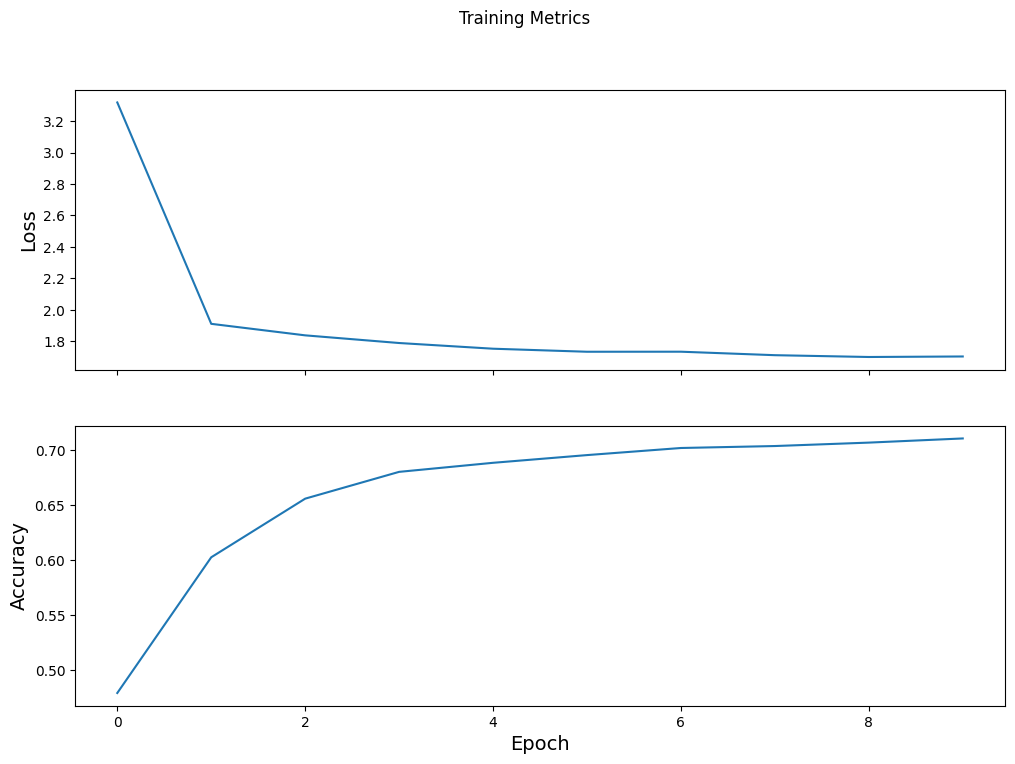

In [ ]:
# Plot the training loss and accuracy

fig, axes = plt.subplots(2, sharex=True, figsize=(12, 8))
fig.suptitle('Training Metrics')

axes[0].set_ylabel("Loss", fontsize=14)
axes[0].plot(train_loss_results)

axes[1].set_ylabel("Accuracy", fontsize=14)
axes[1].set_xlabel("Epoch", fontsize=14)
axes[1].plot(train_accuracy_results)
plt.show()

#### Predict from the model

In [ ]:
# Get the model prediction for an example input

predicted_label = np.argmax(model(x_train[np.newaxis,0]),axis=1)[0]
print("Prediction: {}".format(class_names[predicted_label]))
print("     Label: {}".format(class_names[train_labels[0]]))

Prediction: earn
     Label: earn
